# Mask R-CNN - Train on Doremi

In [77]:
import os
import sys
import random
import math
import re
import glob
import time
import numpy as np
import datetime
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
from tqdm import tqdm
from xml.dom import minidom
from mrcnn.config import Config

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn.utils import Dataset
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

import skimage.draw
from keras import backend as K

# Path to classnames file
CLASSNAMES_PATH = "/import/c4dm-05/elona/doremi_v5_half/train_validation_test_records/mapping.json"

# Path to XML Train files
XML_DATA_PATH = '/homes/es314/DOREMI_version_2/MRCNN_DOREMI_20210503/dataset/'
# XML_TRAIN_PATH = '/homes/es314/DOREMI_version_2/MRCNN_DOREMI_20210503/dataset/train/'
# Path to XML Val files
# XML_VAL_PATH = '/homes/es314/DOREMI_version_2/MRCNN_DOREMI_20210503/dataset/val/'

# Path to Images 
IMG_PATH = '/homes/es314/DOREMI_version_2/DOREMI_v3/images/'
# Path to trained weights file
# COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "weights/mask_rcnn_coco.h5")
COCO_WEIGHTS_PATH = '/homes/es314/DOREMI_version_2/MRCNN_DOREMI_20210503/weights/mask_rcnn_coco.h5'
# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
# DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
DEFAULT_LOGS_DIR = '/homes/es314/DOREMI_version_2/MRCNN_DOREMI_20210503/logs_resnet50'

# Configurations

In [78]:
class DoremiConfig(Config):
    """
    Configuration for training on the Doremi dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "doremi"

    # We use a GPU with ??GB memory, which can fit ??? images. (12gb can fit 2 images)
    # Adjust down if you use a smaller/bigger GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 71  # Background + 71 classes

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

    # Our image size 
    # IMAGE_RESIZE_MODE = "none"
    # IMAGE_MAX_DIM = 3520
    BACKBONE = "resnet50"

In [79]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

# Notebook Preferences

In [80]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


# Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, load_shapes(), and override the following methods:

- load_image()
- load_mask()
- image_reference()



In [81]:
class DoremiDataset(utils.Dataset):
    def load_doremi(self, subset):
        """
        Load a subset of the Foremi dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        # self.add_class("doremi", class_id, "classname")
        with open(CLASSNAMES_PATH) as json_file:
            data = json.load(json_file)
            for id_class in data:
                self.add_class("doremi", id_class["id"], id_class["name"])

        # Train or validation dataset?
        assert subset in ["train", "val"]
        # dataset_dir = os.path.join(dataset_dir, subset)
        dataset_dir = XML_DATA_PATH+subset+'/*.xml'
        available_xml = glob.glob(dataset_dir)
        # xml_count = len(available_xml)

        # Go through all XML Files
        # Each XML File is 1 Page, each page corresponds to 1 image
        for xml_file in tqdm(available_xml, desc="XML Files"):
            filename = os.path.basename(xml_file)
            # Remove .xml from end of file
            filename = filename[:-4]

            # Parse XML Document
            xmldoc = minidom.parse(xml_file)

            # Get image name from XML file name
            page = xmldoc.getElementsByTagName('Page')
            page_index_str = page[0].attributes['pageIndex'].value

            page_index_int = int(page_index_str) + 1
            # Open image related to XML file
            # /homes/es314/DOREMI_version_2/data_v5/parsed_by_classnames/Parsed_accidental tucking-layout-0-muscima_Page_2.xml
            # Parsed_accidental tucking-layout-0-muscima_Page_2.xml
            # Remove '-layout-0-muscima_Page_' (23 chars) + len of page_index_str

            # Image name
            # /homes/es314/DOREMI_version_2/DOREMI_v3/images/accidental tucking-002.png
            # accidental tucking-002.png

            ending = 23 + len(str(page_index_int))

            start_str = 'Parsed_'
            # If page is 0, we need to add '000'
            leading_zeroes = str(page_index_int).zfill(3)
            img_filename = filename[len(start_str):-ending]+'-'+leading_zeroes
            img_filename = img_filename+'.png'
            # /homes/es314/DOREMI_version_2/DOREMI_v3/images/beam groups 12 demisemiquavers simple-918.png'

            img_path = IMG_PATH + img_filename
            # Hardcoded because our images have the same shape
            img_height = 3504
            img_width = 2474

            mask_arr = []

            nodes = xmldoc.getElementsByTagName('Node')
            # print('nodes len: ', len(nodes))

            instances_count = len(xmldoc.getElementsByTagName('ClassName'))

            # Array containing mask info object that we will use in load_mask
            masks_info = []
            # {
            #     "bbox_top": int
            #     "bbox_left": int
            #     "bbox_width": int
            #     "bbox_height": int
            #     "mask_arr": [int]
            #     "classname": str
            # }
            for node in nodes:
                this_mask_info = {}
                # Classname
                node_classname_el = node.getElementsByTagName('ClassName')[0]
                node_classname = node_classname_el.firstChild.data
                # Top
                node_top = node.getElementsByTagName('Top')[0]
                node_top_int = int(node_top.firstChild.data)
                # Left
                node_left = node.getElementsByTagName('Left')[0]
                node_left_int = int(node_left.firstChild.data)
                # Width
                node_width = node.getElementsByTagName('Width')[0]
                node_width_int = int(node_width.firstChild.data)
                # Height
                node_height = node.getElementsByTagName('Height')[0]
                node_height_int = int(node_height.firstChild.data)

                node_mask = str(node.getElementsByTagName('Mask')[0].firstChild.data)
                # 0: 2 1: 7 0: 9 1: 3
                node_mask = node_mask.replace('0:', '')
                # 2 1: 7 9 1: 3
                node_mask = node_mask.replace('1:', '')
                # 2 7 9 3
                split_mask = node_mask.split(' ')
                # [2, 7, 9, 3]
                split_mask = split_mask[:-1]
                
                notehead_counts = list(map(int, list(split_mask)))

                this_mask_info["classname"] = node_classname
                this_mask_info["bbox_top"] = node_top_int
                this_mask_info["bbox_left"] = node_left_int
                this_mask_info["bbox_width"] = node_width_int
                this_mask_info["bbox_height"] = node_height_int
                this_mask_info["mask_arr"] = notehead_counts

                masks_info.append(this_mask_info)


            # 3 required attributes, rest is kwargs
            # image_info = {
            #     "id": image_id,
            #     "source": source,
            #     "path": path,
            # }
            self.add_image(
                    "doremi",
                    image_id=img_filename,  # use file name as a unique image id
                    path=img_path,
                    img_width=img_width, img_height=img_height,
                    masks_info=masks_info)

    def load_mask(self, image_id):
        """
        Generate instance masks for an image.
        Should returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        info = self.image_info[image_id]
        if info["source"] != "doremi":
            return super(self.__class__, self).load_mask(image_id)
        
        img_height = info["img_height"]
        img_width = info["img_width"]
        mask = np.zeros([img_height, img_width, len(info["masks_info"])],dtype=np.uint8)
        instances_classes = []
        ids_classnames = {}
        with open(CLASSNAMES_PATH) as json_file:
            data = json.load(json_file)
            for id_class in data:
                ids_classnames[id_class["name"]] = id_class["id"]
        for it, info in enumerate(info["masks_info"]):
            class_id = ids_classnames[info["classname"]]
            instances_classes.append(class_id)

            notehead_counts = info["mask_arr"]
            node_top_int = info["bbox_top"]
            node_left_int = info["bbox_left"]
            node_width_int = info["bbox_width"]
            node_height_int = info["bbox_height"]
            # Counts start with Zero
            zero = True
            i = node_top_int
            j = node_left_int

            for count in notehead_counts:
                # If first 0 count is zero, ignore and go to 1
                if count != 0:
                    for _ in range(count):
                        if not zero:
                            mask[i, j, it] = 1

                        j = j + 1
                        if j == img_width or j == node_left_int+node_width_int:
                            j = node_left_int
                            i = i + 1
                zero = not zero
        # Return mask, and array of class IDs of each instance.
        return mask.astype(np.bool), np.array(instances_classes, dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "doremi":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

# Loading Training and Validation Dataset

In [82]:
 # Training dataset.
dataset_train = DoremiDataset()
dataset_train.load_doremi("train")
dataset_train.prepare()

# Validation dataset
dataset_val = DoremiDataset()
dataset_val.load_doremi("val")
dataset_val.prepare()

XML Files: 100%|██████████| 88/88 [00:04<00:00, 18.56it/s]


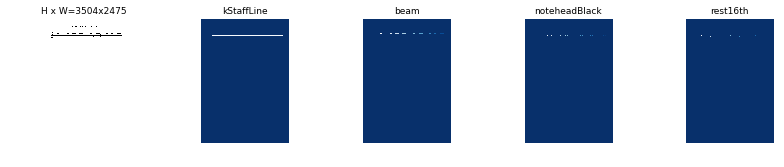

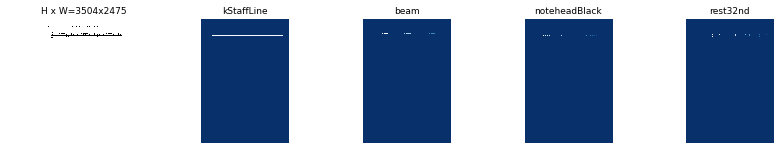

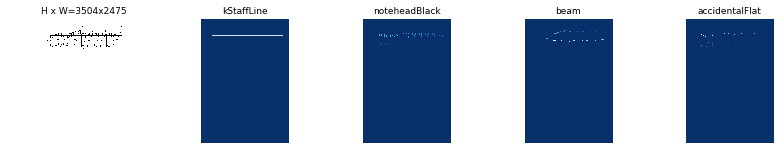

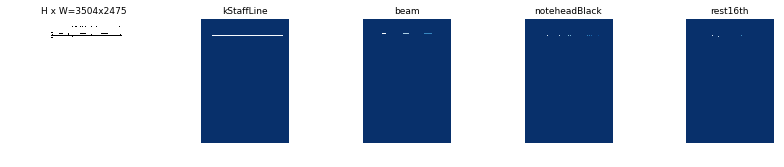

In [83]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)

for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

image_id  248 /homes/es314/DOREMI_version_2/DOREMI_v3/images/beam groups 12 semiquavers simple-1038.png
image                    shape: (3504, 2475, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (3504, 2474, 87)      min:    0.00000  max:    1.00000  bool
class_ids                shape: (87,)                 min:   20.00000  max:   56.00000  int32
bbox                     shape: (87, 4)               min:  299.00000  max: 2300.00000  int32


ValueError: operands could not be broadcast together with shapes (3504,2474) (3504,2475) (3504,2475) 

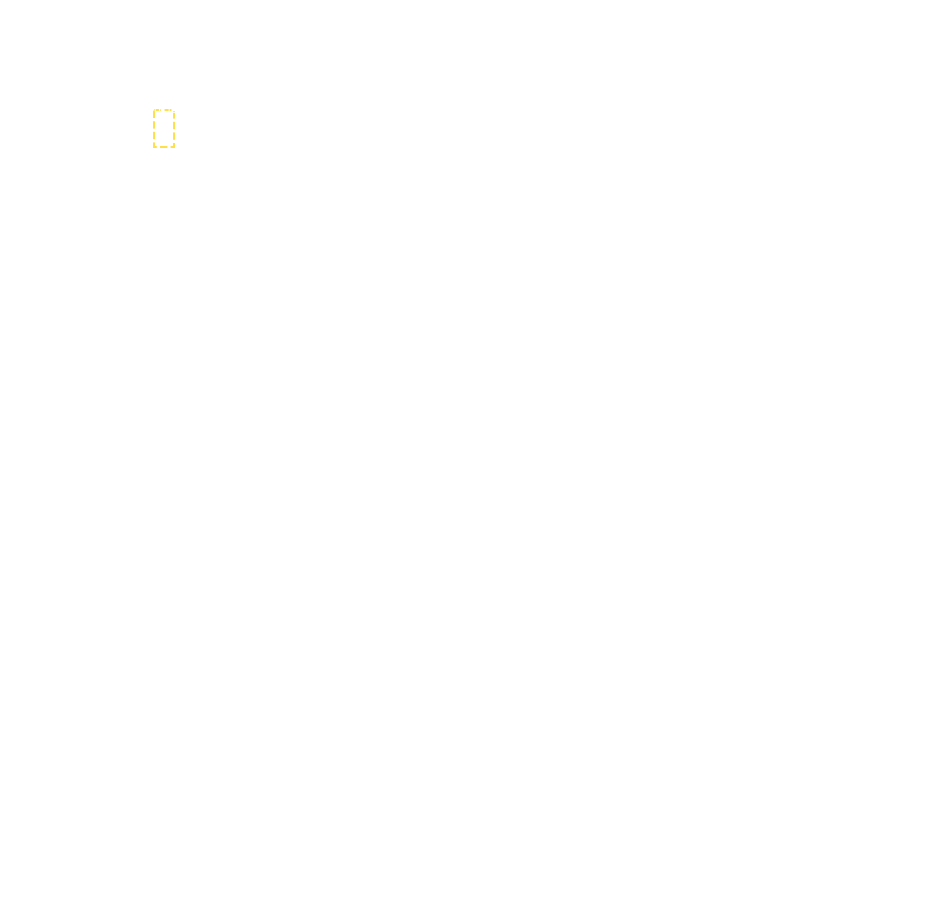

In [84]:
# Load random image and mask.
image_id = random.choice(dataset_train.image_ids)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset_train.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

# Training

## The example code trains in two stages:

- Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

- Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.

## Choose what's best for this dataset


# Detection

In [ ]:
MODEL_DIR = '/homes/es314/DOREMI_version_2/MRCNN_DOREMI_20210503/logs'

class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)